In [ ]:
!pip install transformers
!pip install gensim

In [5]:
import numpy as np
import pandas as pd

import re
import string

import transformers
from transformers import AutoTokenizer
import gensim
import gensim.downloader

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Text Processing

In [7]:
df = pd.read_csv('/content/drive/MyDrive/ay2324 sem1/cs3244/project/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Null removals

In [8]:
print(f"initial dataframe has {len(df)} rows.")
null_rows = df[df.isnull().values.any(1)]
print(f"dataframe has {len(null_rows)} null rows.")
df.dropna(how='any', inplace=True)
print(f"dataframe has {len(df)} rows after removing null values.")

initial dataframe has 404290 rows.
dataframe has 3 null rows.
dataframe has 404287 rows after removing null values.


In [9]:
num_samples = len(df)
num_samples

404287

### Splitting

In [10]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [11]:
# split into train/val, test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((258743, 5), (64686, 5), (80858, 5))

### Cleaning

In [13]:
def clean_text(text):
    text = text.lower() # lower case
    text = re.sub('\s+\n+', ' ', text)
    text = re.sub(f"[{''.join(char for char in string.punctuation if char != '?')}]", ' ', text) # remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s?]', ' ', text) # remove special chars

    return text

demo_qn = "What's the meaning of life?"
clean_text(demo_qn)

'what s the meaning of life?'

In [14]:
X_train['q1_cleaned'] = X_train['question1'].apply(clean_text)
X_train['q2_cleaned'] = X_train['question2'].apply(clean_text)
X_train.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned
217908,217908,184295,83786,"Where can I find the uncut, uncensored Fifty S...",What's the best way to see Fifty Shades of Gre...,where can i find the uncut uncensored fifty s...,what s the best way to see fifty shades of gre...
103880,103880,171594,171595,"In the Quora iPhone app, is there a way to see...",How can I filter my content to see which quest...,in the quora iphone app is there a way to see...,how can i filter my content to see which quest...
252876,252876,158209,367298,College Applications: What does it take to get...,How much score does it take in the SATs (SAT 2...,college applications what does it take to get...,how much score does it take in the sats sat 2...
166262,166262,258027,258028,Which IIT is best for aeronautical engineering?,How can progress a civildroftman to civilengin...,which iit is best for aeronautical engineering?,how can progress a civildroftman to civilengin...
146340,146340,231187,231188,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,what is the legality behind copying and pastin...,is it legal to copy news from other sites?
332298,332298,432679,62027,What is the size of a profile photo on Instagram?,How can I see a full-size profile picture of s...,what is the size of a profile photo on instagram?,how can i see a full size profile picture of s...
217255,217255,323566,100138,What order should I watch DC movies?,What is the order of the Alien movies? Should ...,what order should i watch dc movies?,what is the order of the alien movies? should ...
309217,309217,433171,235300,The U.S. Treasury Department mints a American ...,"Why do US banks not accept coins, considering ...",the u s treasury department mints a american ...,why do us banks not accept coins considering ...
185878,185878,214968,283666,Why do people keep their black money in Swiss ...,Why is black money kept in Swiss bank accounts?,why do people keep their black money in swiss ...,why is black money kept in swiss bank accounts?
140998,140998,223948,223949,Do Jews believe in the plagues of Egypt?,Do israeli jews believe in the messiah or not?,do jews believe in the plagues of egypt?,do israeli jews believe in the messiah or not?


### Question Length Analysis

In [15]:
# find word counts of questions
X_train['q1_len'] = X_train['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_train['q2_len'] = X_train['q2_cleaned'].apply(lambda x: len(str(x).split()))
X_train.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_len,q2_len
217908,217908,184295,83786,"Where can I find the uncut, uncensored Fifty S...",What's the best way to see Fifty Shades of Gre...,where can i find the uncut uncensored fifty s...,what s the best way to see fifty shades of gre...,13,13
103880,103880,171594,171595,"In the Quora iPhone app, is there a way to see...",How can I filter my content to see which quest...,in the quora iphone app is there a way to see...,how can i filter my content to see which quest...,20,16
252876,252876,158209,367298,College Applications: What does it take to get...,How much score does it take in the SATs (SAT 2...,college applications what does it take to get...,how much score does it take in the sats sat 2...,14,26
166262,166262,258027,258028,Which IIT is best for aeronautical engineering?,How can progress a civildroftman to civilengin...,which iit is best for aeronautical engineering?,how can progress a civildroftman to civilengin...,7,7
146340,146340,231187,231188,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,what is the legality behind copying and pastin...,is it legal to copy news from other sites?,18,9
332298,332298,432679,62027,What is the size of a profile photo on Instagram?,How can I see a full-size profile picture of s...,what is the size of a profile photo on instagram?,how can i see a full size profile picture of s...,10,13
217255,217255,323566,100138,What order should I watch DC movies?,What is the order of the Alien movies? Should ...,what order should i watch dc movies?,what is the order of the alien movies? should ...,7,18
309217,309217,433171,235300,The U.S. Treasury Department mints a American ...,"Why do US banks not accept coins, considering ...",the u s treasury department mints a american ...,why do us banks not accept coins considering ...,52,13
185878,185878,214968,283666,Why do people keep their black money in Swiss ...,Why is black money kept in Swiss bank accounts?,why do people keep their black money in swiss ...,why is black money kept in swiss bank accounts?,10,9
140998,140998,223948,223949,Do Jews believe in the plagues of Egypt?,Do israeli jews believe in the messiah or not?,do jews believe in the plagues of egypt?,do israeli jews believe in the messiah or not?,8,9


In [14]:
X_train['q1_len'].describe()

count    258743.000000
mean         11.155359
std           5.595920
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         128.000000
Name: q1_len, dtype: float64

In [15]:
X_train['q2_len'].describe()

count    258743.000000
mean         11.378329
std           6.421293
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         248.000000
Name: q2_len, dtype: float64

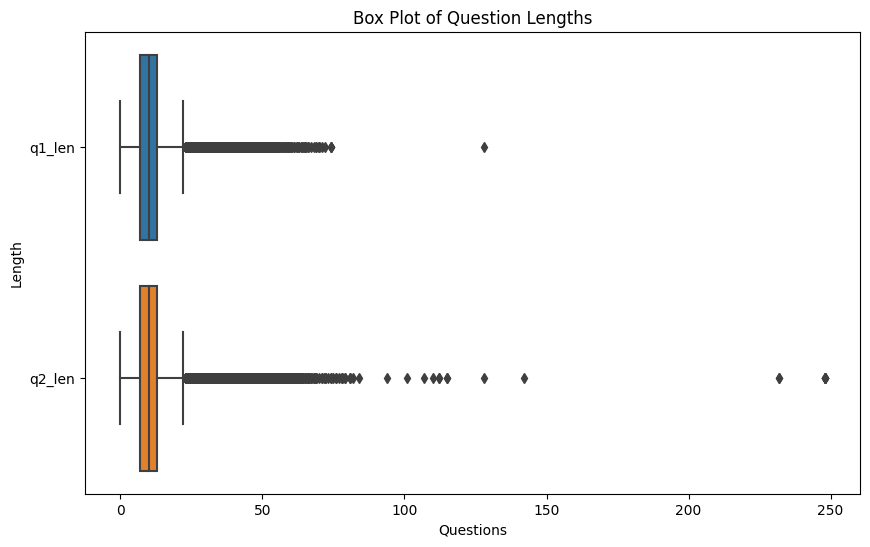

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['q1_len', 'q2_len']], orient='h')
plt.title('Box Plot of Question Lengths')
plt.xlabel('Questions')
plt.ylabel('Length')
plt.show()

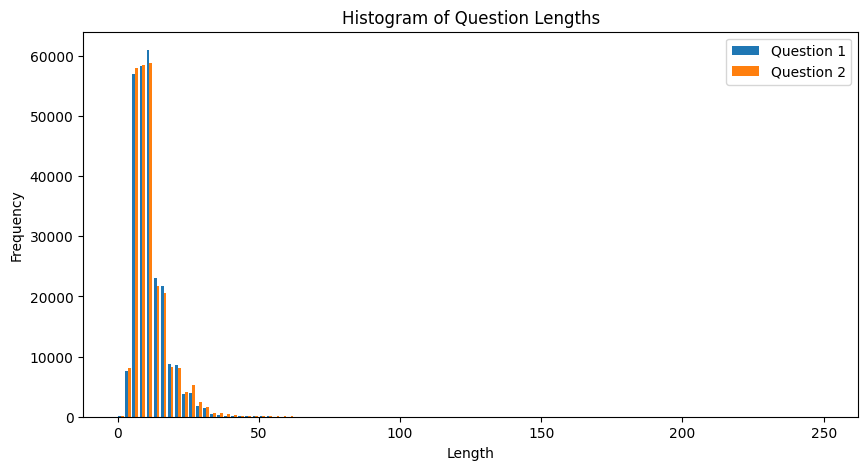

In [17]:
plt.figure(figsize=(10, 5))
plt.hist([X_train['q1_len'], X_train['q2_len']], bins=100, label=['Question 1', 'Question 2'], range=(0, 250))
plt.title('Histogram of Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Determining Ideal Sequence Length

In [18]:
q1_len = X_train['q1_len']
q2_len = X_train['q2_len']

q1_iqr = q1_len.quantile(0.75) - q1_len.quantile(0.25)
q1_outlier = q1_len.quantile(0.75) + 1.5 * q1_iqr

q2_iqr = q2_len.quantile(0.75) - q2_len.quantile(0.25)
q2_outlier = q2_len.quantile(0.75) + 1.5 * q2_iqr
print(f"question 1 length outlier: {q1_outlier}")
print(f"question 2 length outlier: {q2_outlier}")

question 1 length outlier: 22.0
question 2 length outlier: 22.0


Both questions lengths are such that the outlier value (according to the $1.5 \cdot IQR$ rule) is 22 words.

We will choose a sequnce length of 60 to be safe.

## Generate Word Embeddings

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [17]:
X_train['q1_tokens'] = X_train['q1_cleaned'].apply(tokenizer.tokenize)
X_train['q2_tokens'] = X_train['q2_cleaned'].apply(tokenizer.tokenize)

In [18]:
w2v_vecs = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [19]:
EMBEDDING_DIM = 300
MAX_SEQ_LENGTH = 60

def get_embeddings(tokens, embedding_dim=EMBEDDING_DIM, max_sequence_length=MAX_SEQ_LENGTH):
    embeddings = torch.zeros((max_sequence_length, embedding_dim))

    for i, token in enumerate(tokens):
        if i >= max_sequence_length:
            break

        if token in w2v_vecs:
            embeddings[i] = torch.tensor(w2v_vecs[token])
        else:
            continue # ignore OOV tokens
    return embeddings

In [23]:
# requires too much RAM, so cannot precompute
# X_train['q1_embeddings'] = X_train['q1_cleaned'].apply(get_embeddings)
# X_train['q2_embeddings'] = X_train['q2_cleaned'].apply(get_embeddings)

In [24]:
len(w2v_vecs)

3000000

## Obtain Sentence Embeddings (LSTM)

In [20]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))

        # return output of the last time step
        return hn

## Siamese Network with Cosine Similarity and Contrastive Loss

In [18]:
class SiameseNetworkCosineSim(nn.Module):

    def __init__(self, base_model):
        super(SiameseNetworkCosineSim, self).__init__()
        self.base_model = base_model

    def forward(self, q1_embeddings, q2_embeddings):
        embedding1 = self.base_model(q1_embeddings).squeeze(0)
        embedding2 = self.base_model(q2_embeddings).squeeze(0)

        similarity = F.cosine_similarity(embedding1, embedding2, dim=1)
        return similarity  # output is cosine similarity

In [19]:
class ModifiedContrastiveLoss(nn.Module):

    def __init__(self, similar_margin, dissimilar_margin):
        super(ModifiedContrastiveLoss, self).__init__()
        self.similar_margin = similar_margin
        self.dissimilar_margin = dissimilar_margin

    def forward(self, cossim, label):
        # similar_margin must be high, i.e. if duplicate, cossim must be above similar_margin for the loss to be 0
        duplicate_loss = label * torch.clamp(self.similar_margin - cossim, min=0)

        # dissimilar_margin must be low, i.e. if not duplicate, cossim must be lower than dissimilar_margin for the loss to be 0
        not_duplicate_loss = (1 - label) * torch.clamp(cossim - self.dissimilar_margin, min=0)

        loss = duplicate_loss + not_duplicate_loss
        return loss.mean()

## Siamese Network with L1 Distance and Fully Connected Layer

In [21]:
class L1DistanceLayer(nn.Module):

    def __init__(self):
        super(L1DistanceLayer, self).__init__()

    def forward(self, embedding1, embedding2):
        l1_dist = torch.abs(embedding1 - embedding2)
        return l1_dist

class SiameseNetworkWithL1Distance(nn.Module):

    def __init__(self, base_model, embedding_dim, hidden_dim):
        super(SiameseNetworkWithL1Distance, self).__init__()
        self.base_model = base_model
        self.l1_distance = L1DistanceLayer()

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, q1_embeddings, q2_embeddings):
        embedding1 = self.base_model(q1_embeddings).squeeze(0)
        embedding2 = self.base_model(q2_embeddings).squeeze(0)

        l1_dist = self.l1_distance(embedding1, embedding2)

        output = self.fc(l1_dist)
        return output

## Integrating Everything

### Dataset and Data Loader

In [22]:
embedding_dim = 300

class DuplicateQuestionDataset(Dataset):

    def __init__(self, questions, labels):
        self.questions = questions
        self.labels = labels
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q1_tokens, q2_tokens = self.questions[['q1_tokens', 'q2_tokens']].iloc[idx]

        # bottleneck
        q1_embeddings = get_embeddings(q1_tokens, embedding_dim, max_sequence_length=60).to(device)
        q2_embeddings = get_embeddings(q2_tokens, embedding_dim, max_sequence_length=60).to(device)

        label = torch.tensor(self.labels.iloc[idx]).to(device)

        return q1_embeddings, q2_embeddings, label

### Preprocess  Validation and Test Datasets

In [23]:
X_val['q1_cleaned'] = X_val['question1'].apply(clean_text)
X_val['q2_cleaned'] = X_val['question2'].apply(clean_text)

# find word counts of questions
X_val['q1_len'] = X_val['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_val['q2_len'] = X_val['q2_cleaned'].apply(lambda x: len(str(x).split()))

X_val['q1_tokens'] = X_val['q1_cleaned'].apply(tokenizer.tokenize)
X_val['q2_tokens'] = X_val['q2_cleaned'].apply(tokenizer.tokenize)

X_val.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_len,q2_len,q1_tokens,q2_tokens
238575,238575,188940,349975,What are some inventions of the Renaissance re...,What are some inventions of the Renaissance re...,what are some inventions of the renaissance re...,what are some inventions of the renaissance re...,9,9,"[what, are, some, inventions, of, the, renaiss...","[what, are, some, inventions, of, the, renaiss..."
55283,55283,97481,97482,Did Instacart get into YC two months after the...,Does it hurt to wait to submit our YC app unti...,did instacart get into yc two months after the...,does it hurt to wait to submit our yc app unti...,16,15,"[did, ins, ##ta, ##car, ##t, get, into, y, ##c...","[does, it, hurt, to, wait, to, submit, our, y,..."
168650,168650,261185,261186,Am I bipolar If I Do Things To Stay Awake?,Am I bipolar if I do things to stay up all night?,am i bipolar if i do things to stay awake?,am i bipolar if i do things to stay up all night?,10,12,"[am, i, bipolar, if, i, do, things, to, stay, ...","[am, i, bipolar, if, i, do, things, to, stay, ..."
375327,375327,506336,214461,Where are the best splunk video tutorials?,Why is Splunk so successful?,where are the best splunk video tutorials?,why is splunk so successful?,7,5,"[where, are, the, best, sp, ##lun, ##k, video,...","[why, is, sp, ##lun, ##k, so, successful, ?]"
180642,180642,276907,276908,How can you make a sequence diagram of a libra...,How is a case diagram of library management sy...,how can you make a sequence diagram of a libra...,how is a case diagram of library management sy...,12,10,"[how, can, you, make, a, sequence, diagram, of...","[how, is, a, case, diagram, of, library, manag..."
28165,28165,52250,52251,How can tiny white bumps on your hands be trea...,What are small white bumps on your hands called?,how can tiny white bumps on your hands be trea...,what are small white bumps on your hands called?,10,9,"[how, can, tiny, white, bumps, on, your, hands...","[what, are, small, white, bumps, on, your, han..."
16441,16441,31345,31346,How do I get backlinks to my website without g...,How can I get more backlinks to my website?,how do i get backlinks to my website without g...,how can i get more backlinks to my website?,10,9,"[how, do, i, get, back, ##link, ##s, to, my, w...","[how, can, i, get, more, back, ##link, ##s, to..."
213959,213959,319429,319430,How do I ask silly things?,Which is the best thing to ask during a chat?,how do i ask silly things?,which is the best thing to ask during a chat?,6,10,"[how, do, i, ask, silly, things, ?]","[which, is, the, best, thing, to, ask, during,..."
98147,98147,75911,160998,How do I prepare for CAT in one month?,What should be the strategy to prepare for CAT...,how do i prepare for cat in one month?,what should be the strategy to prepare for cat...,9,13,"[how, do, i, prepare, for, cat, in, one, month...","[what, should, be, the, strategy, to, prepare,..."
216057,216057,103274,322104,Why do man love boobs?,Why do we love boobs?,why do man love boobs?,why do we love boobs?,5,5,"[why, do, man, love, boo, ##bs, ?]","[why, do, we, love, boo, ##bs, ?]"


In [24]:
X_test['q1_cleaned'] = X_test['question1'].apply(clean_text)
X_test['q2_cleaned'] = X_test['question2'].apply(clean_text)

# find word counts of questions
X_test['q1_len'] = X_test['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_test['q2_len'] = X_test['q2_cleaned'].apply(lambda x: len(str(x).split()))

X_test['q1_tokens'] = X_test['q1_cleaned'].apply(tokenizer.tokenize)
X_test['q2_tokens'] = X_test['q2_cleaned'].apply(tokenizer.tokenize)

X_test.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_len,q2_len,q1_tokens,q2_tokens
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,how do i play pok mon go in korea?,how do i play pok mon go in china?,9,9,"[how, do, i, play, po, ##k, mon, go, in, korea...","[how, do, i, play, po, ##k, mon, go, in, china..."
224279,224279,332326,332327,Will a breathing treatment help a cough?,How can I help someone that is unconscious but...,will a breathing treatment help a cough?,how can i help someone that is unconscious but...,7,11,"[will, a, breathing, treatment, help, a, cough...","[how, can, i, help, someone, that, is, unconsc..."
252452,252452,336023,366789,Is Kellyanne Conway annoying in your opinion?,Did Kellyanne Conway really imply that we shou...,is kellyanne conway annoying in your opinion?,did kellyanne conway really imply that we shou...,7,22,"[is, kelly, ##anne, conway, annoying, in, your...","[did, kelly, ##anne, conway, really, imply, th..."
174039,174039,268330,268331,How do you rate (1-10) and review Maruti Baleno?,What career options does one have after comple...,how do you rate 1 10 and review maruti baleno?,what career options does one have after comple...,10,21,"[how, do, you, rate, 1, 10, and, review, maru,...","[what, career, options, does, one, have, after..."
384863,384863,28901,233483,What are some good books on marketing?,What are some of the best books ever written a...,what are some good books on marketing?,what are some of the best books ever written a...,7,11,"[what, are, some, good, books, on, marketing, ?]","[what, are, some, of, the, best, books, ever, ..."
182965,182965,1120,7681,What can be the medium budget to visit best pl...,What are the best places to visit on a 3 day t...,what can be the medium budget to visit best pl...,what are the best places to visit on a 3 day t...,19,16,"[what, can, be, the, medium, budget, to, visit...","[what, are, the, best, places, to, visit, on, ..."
199717,199717,301285,301286,"A boy rufused me, how can I continue to keep t...",What is difference between RCS and VoLTE?,a boy rufused me how can i continue to keep t...,what is difference between rcs and volte?,14,7,"[a, boy, rufus, ##ed, me, how, can, i, continu...","[what, is, difference, between, rc, ##s, and, ..."
343232,343232,471320,127014,How many Hindu nations are in the world?,"What are First World, Second World and Third W...",how many hindu nations are in the world?,what are first world second world and third w...,8,10,"[how, many, hindu, nations, are, in, the, worl...","[what, are, first, world, second, world, and, ..."
91165,91165,152829,152830,What are the economic advantages of cashless p...,Is it possible to have a totally cashless paym...,what are the economic advantages of cashless p...,is it possible to have a totally cashless paym...,8,21,"[what, are, the, economic, advantages, of, cas...","[is, it, possible, to, have, a, totally, cash,..."
110222,110222,158902,125399,Why cant I get a credit card with no credit?,What is the fastest way to get a credit card?,why cant i get a credit card with no credit?,what is the fastest way to get a credit card?,10,10,"[why, can, ##t, i, get, a, credit, card, with,...","[what, is, the, fastest, way, to, get, a, cred..."


In [25]:
# batch size
batch_size = 64

train_dataset = DuplicateQuestionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Hyperparameters

In [26]:
# LSTM hyperparameters
embedding_dim = 300
rnn_hidden_size = 300
fcn_hidden_size = 600
num_layers = 1

learning_rate = 0.001

In [34]:
# for modified contrastive loss
similar_margin = 0.75
dissimilar_margin = -0.5

### Model Initialisation

In [35]:
base_model = LSTMModel(embedding_dim, rnn_hidden_size, num_layers).to(device)
siamese_model = SiameseNetworkWithL1Distance(base_model, embedding_dim, fcn_hidden_size).to(device)

siamese_model.train()

SiameseNetworkWithL1Distance(
  (base_model): LSTMModel(
    (lstm): LSTM(300, 300, batch_first=True)
  )
  (l1_distance): L1DistanceLayer()
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [36]:
# base_model = LSTMModel(embedding_dim, hidden_size, num_layers).to(device)
# siamese_model = SiameseNetworkCosineSim(base_model).to(device)

# siamese_model.train()

### Optimizers & Loss

The modified contrastive loss did not work as expected. Extremely low accuracy scores were obtained, which was worse than random chance (around 30-40%) which meant that the model might have been optimising for something else.

In [37]:
# optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate)
# criterion = ModifiedContrastiveLoss(similar_margin, dissimilar_margin)

In [32]:
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [39]:
total_params = sum(p.numel() for p in siamese_model.parameters())
total_params

903601

### Model Training

In [ ]:
num_epochs = 5
lossi = []

base_lstm_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/lstm_model.pth'
siamese_model_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/siamese_model.pth'

siamese_model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for q1_embeddings, q2_embeddings, labels in tqdm(train_loader):
        optimizer.zero_grad()

        output = siamese_model(q1_embeddings, q2_embeddings)
        loss = criterion(output.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()

        lossi.append(loss.item())
        total_loss += loss.item()

    torch.save(base_model.state_dict(), base_lstm_path)
    torch.save(siamese_model.state_dict(), siamese_model_path)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

  0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 1, Loss: 0.3110


  0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 2, Loss: 0.2450


  0%|          | 0/4043 [00:00<?, ?it/s]

### Visualising Loss

In [ ]:
average_lossi = torch.tensor(lossi).view(-1, 4043).mean(1)
plt.plot(average_lossi)
plt.title('Training Loss')

## Saving Model

In [27]:
base_lstm_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/lstm_model.pth'
siamese_model_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/siamese_model.pth'

In [ ]:
torch.save(base_model.state_dict(), base_lstm_path)
torch.save(siamese_model.state_dict(), siamese_model_path)

## Loading Model

In [28]:
embedding_dim = 300
rnn_hidden_size = 300
fcn_hidden_size = 600
num_layers = 1

base_model = LSTMModel(embedding_dim, rnn_hidden_size, num_layers).to(device)
base_model.load_state_dict(torch.load(base_lstm_path))

siamese_model = SiameseNetworkWithL1Distance(base_model, embedding_dim, fcn_hidden_size).to(device)
siamese_model.load_state_dict(torch.load(siamese_model_path))

siamese_model.eval()

SiameseNetworkWithL1Distance(
  (base_model): LSTMModel(
    (lstm): LSTM(300, 300, batch_first=True)
  )
  (l1_distance): L1DistanceLayer()
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

## Model Evaluation

### Training Accuracy

In [29]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_train = []
    predicted_scores_train = []
    for q1_embeddings, q2_embeddings, labels in tqdm(train_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_train.extend(labels.cpu().numpy())
        predicted_scores_train.extend(outputs.cpu().numpy())

true_labels_train = np.array(true_labels_train)
predicted_scores_train = np.array(predicted_scores_train)

accuracy = accuracy_score(true_labels_train, (predicted_scores_train > threshold)) * 100
print(f"Train Accuracy: {accuracy:.2f}%")

  0%|          | 0/4043 [00:00<?, ?it/s]

Train Accuracy: 92.52%


### Validation Accuracy

In [33]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_val = []
    predicted_scores_val = []
    for q1_embeddings, q2_embeddings, labels in tqdm(val_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_val.extend(labels.cpu().numpy())
        predicted_scores_val.extend(outputs.cpu().numpy())

true_labels_val = np.array(true_labels_val)
predicted_scores_val = np.array(predicted_scores_val)

accuracy = accuracy_score(true_labels_val, (predicted_scores_val > threshold)) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

  0%|          | 0/1011 [00:00<?, ?it/s]

Validation Accuracy: 83.11%


### Test Accuracy

In [32]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_test = []
    predicted_scores_test = []
    for q1_embeddings, q2_embeddings, labels in tqdm(test_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_test.extend(labels.cpu().numpy())
        predicted_scores_test.extend(outputs.cpu().numpy())

true_labels_test = np.array(true_labels_test)
predicted_scores_test = np.array(predicted_scores_test)

accuracy = accuracy_score(true_labels_test, (predicted_scores_test > threshold)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/1264 [00:00<?, ?it/s]

Test Accuracy: 82.95%


## Other Classification Metrics

In [34]:
def print_classification_metrics(dataset='test'):
    labels = {
        'train': (true_labels_train, predicted_scores_train),
        'val': (true_labels_val, predicted_scores_val),
        'test': (true_labels_test, predicted_scores_test)
    }
    true, predicted = labels[dataset]

    print(classification_report(true, (predicted > threshold)))

    fpr, tpr, _ = roc_curve(true, predicted)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset.capitalize()} Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.94      0.94      0.94    163265
           1       0.90      0.90      0.90     95478

    accuracy                           0.93    258743
   macro avg       0.92      0.92      0.92    258743
weighted avg       0.93      0.93      0.93    258743



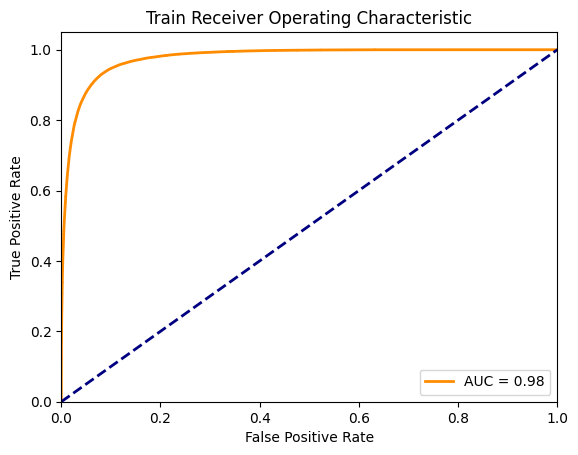

AUC-ROC: 0.98


In [35]:
print_classification_metrics(dataset='train')

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     40733
           1       0.77      0.77      0.77     23953

    accuracy                           0.83     64686
   macro avg       0.82      0.82      0.82     64686
weighted avg       0.83      0.83      0.83     64686



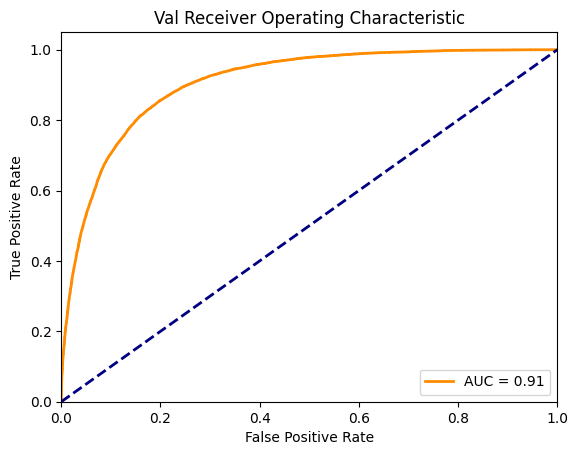

AUC-ROC: 0.91


In [36]:
print_classification_metrics(dataset='val')

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     51026
           1       0.77      0.78      0.77     29832

    accuracy                           0.83     80858
   macro avg       0.82      0.82      0.82     80858
weighted avg       0.83      0.83      0.83     80858



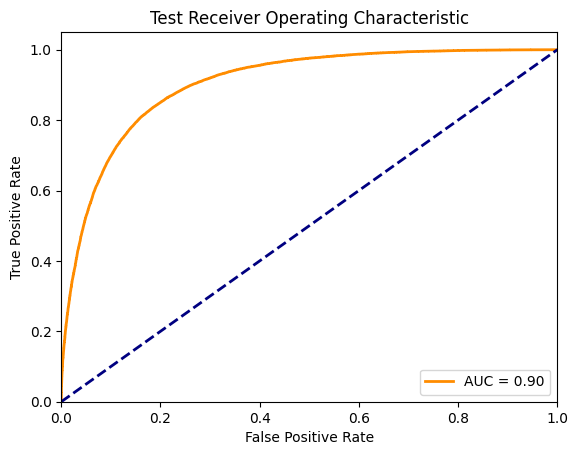

AUC-ROC: 0.90


In [37]:
print_classification_metrics(dataset='test')